<a href="https://colab.research.google.com/github/mertorelio/machine_learning_notes/blob/master/home_credit_default_risk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 * Ön işleme

* Model validasyonu (Train-Test Split)

* Base Modelin Degerlendirmesi

* Feature selection lofo-importance 

* Optuna ile Hyperparametre optimizasyonu

* Degerlendirme

# Kurulumlar ve import islemleri

In [ ]:
!pip install catboost

In [ ]:
!pip install optuna 

In [ ]:
!pip install lofo-importance

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.linear_model import RidgeClassifier
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from lofo import LOFOImportance, Dataset, plot_importance
import optuna

In [ ]:
def unzip_data(filename):
  """
  Unzips filename into the current working directory.

  Args:
    filename (str): a filepath to a target zip folder to be unzipped.
  """
  zip_ref = zipfile.ZipFile(filename, "r")
  zip_ref.extractall()
  zip_ref.close()

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def evaluate_classification(y_true, y_pred):
    """
    y_true: gerçek sınıf etiketleri
    y_pred: modelin tahmin ettiği sınıf etiketleri
    """
    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred)
    
    return {
        'Accuracy': acc,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'ROC-AUC': roc_auc
    }

In [ ]:
unzip_data("/content/application_train.csv.zip")

Veriyi okuma

In [ ]:
data = pd.read_csv('/content/application_train.csv')

#1 ) Veriyi Inceleme Ve Önişlemler

In [ ]:
print('Training data shape: ', data.shape)
data.head()

Training data shape:  (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


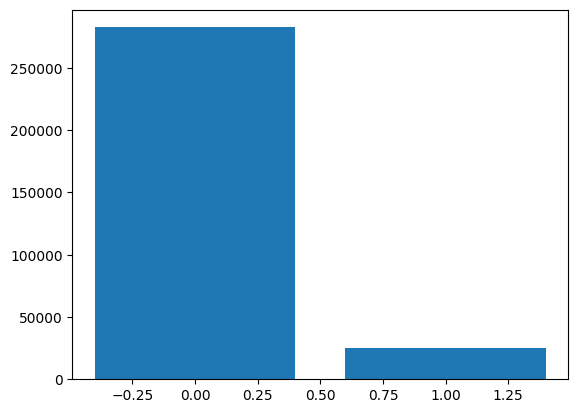

In [ ]:
value_counts = data['TARGET'].value_counts()

plt.bar(value_counts.index, value_counts.values)
plt.show()

In [ ]:
data['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

Veriseti dengesiz. Label dagilimlari modeli etkileyebilir fakat bazi algoritmalar bundan etkilenemzler

In [ ]:
data.isnull().sum()

SK_ID_CURR                        0
TARGET                            0
NAME_CONTRACT_TYPE                0
CODE_GENDER                       0
FLAG_OWN_CAR                      0
                              ...  
AMT_REQ_CREDIT_BUREAU_DAY     41519
AMT_REQ_CREDIT_BUREAU_WEEK    41519
AMT_REQ_CREDIT_BUREAU_MON     41519
AMT_REQ_CREDIT_BUREAU_QRT     41519
AMT_REQ_CREDIT_BUREAU_YEAR    41519
Length: 122, dtype: int64

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


In [ ]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
SK_ID_CURR,307511.0,278180.518577,102790.175348,100002.0,189145.5,278202.0,367142.5,456255.0
TARGET,307511.0,0.080729,0.272419,0.0,0.0,0.0,0.0,1.0
CNT_CHILDREN,307511.0,0.417052,0.722121,0.0,0.0,0.0,1.0,19.0
AMT_INCOME_TOTAL,307511.0,168797.919297,237123.146279,25650.0,112500.0,147150.0,202500.0,117000000.0
AMT_CREDIT,307511.0,599025.999706,402490.776996,45000.0,270000.0,513531.0,808650.0,4050000.0
...,...,...,...,...,...,...,...,...
AMT_REQ_CREDIT_BUREAU_DAY,265992.0,0.007000,0.110757,0.0,0.0,0.0,0.0,9.0
AMT_REQ_CREDIT_BUREAU_WEEK,265992.0,0.034362,0.204685,0.0,0.0,0.0,0.0,8.0
AMT_REQ_CREDIT_BUREAU_MON,265992.0,0.267395,0.916002,0.0,0.0,0.0,0.0,27.0
AMT_REQ_CREDIT_BUREAU_QRT,265992.0,0.265474,0.794056,0.0,0.0,0.0,0.0,261.0


**Eksik Verilerle ilgilenme**

In [ ]:
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns
    
missing_values = missing_values_table(data)
missing_values.head(20)

Your selected dataframe has 122 columns.
There are 67 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
FONDKAPREMONT_MODE,210295,68.4
LIVINGAPARTMENTS_MODE,210199,68.4
LIVINGAPARTMENTS_MEDI,210199,68.4
LIVINGAPARTMENTS_AVG,210199,68.4


**Eksik Verileri Dolduralim**

* data_v1 salt hali
* data_v2 Nan degerlerinin ortalama ile doldurulmus hali

In [ ]:
data_v1 = data

In [ ]:
data_v2 = data.fillna(data.mean())

<ipython-input-18-66dc530b72c8>:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  data_v2 = data.fillna(data.mean())


In [ ]:
missing_values = missing_values_table(data_v2)
missing_values.head(20)

Your selected dataframe has 122 columns.
There are 6 columns that have missing values.


,Missing Values,% of Total Values
FONDKAPREMONT_MODE,210295,68.4
WALLSMATERIAL_MODE,156341,50.8
HOUSETYPE_MODE,154297,50.2
EMERGENCYSTATE_MODE,145755,47.4
OCCUPATION_TYPE,96391,31.3
NAME_TYPE_SUITE,1292,0.4


In [ ]:
data_v2["FONDKAPREMONT_MODE"].value_counts()

reg oper account         73830
reg oper spec account    12080
not specified             5687
org spec account          5619
Name: FONDKAPREMONT_MODE, dtype: int64

In [ ]:
data_v2["FONDKAPREMONT_MODE"].fillna("reg oper account", inplace=True)

In [ ]:
data_v2["WALLSMATERIAL_MODE"].value_counts()

Panel           66040
Stone, brick    64815
Block            9253
Wooden           5362
Mixed            2296
Monolithic       1779
Others           1625
Name: WALLSMATERIAL_MODE, dtype: int64

In [ ]:
values = ["Panel", "Stone, brick"]
data_v2["WALLSMATERIAL_MODE"] = data_v2["WALLSMATERIAL_MODE"].fillna(pd.Series(np.random.choice(values, size=len(data_v2.index))))

In [ ]:
data_v2["FONDKAPREMONT_MODE"].fillna("reg oper account", inplace=True)

In [ ]:
data_v2["HOUSETYPE_MODE"].value_counts()

block of flats      150503
specific housing      1499
terraced house        1212
Name: HOUSETYPE_MODE, dtype: int64

In [ ]:
data_v2["HOUSETYPE_MODE"].fillna("block of flats", inplace=True)

In [ ]:
data_v2["EMERGENCYSTATE_MODE"].value_counts()

No     159428
Yes      2328
Name: EMERGENCYSTATE_MODE, dtype: int64

In [ ]:
data_v2["EMERGENCYSTATE_MODE"].fillna("No", inplace=True)

In [ ]:
data_v2["OCCUPATION_TYPE"].value_counts()

Laborers                 55186
Sales staff              32102
Core staff               27570
Managers                 21371
Drivers                  18603
High skill tech staff    11380
Accountants               9813
Medicine staff            8537
Security staff            6721
Cooking staff             5946
Cleaning staff            4653
Private service staff     2652
Low-skill Laborers        2093
Waiters/barmen staff      1348
Secretaries               1305
Realty agents              751
HR staff                   563
IT staff                   526
Name: OCCUPATION_TYPE, dtype: int64

In [ ]:
values = ["Laborers", "Sales staff","Core staff","Managers"]
data_v2["OCCUPATION_TYPE"] = data_v2["OCCUPATION_TYPE"].fillna(pd.Series(np.random.choice(values, size=len(data_v2.index))))

In [ ]:
data_v2["NAME_TYPE_SUITE"].value_counts()

Unaccompanied      248526
Family              40149
Spouse, partner     11370
Children             3267
Other_B              1770
Other_A               866
Group of people       271
Name: NAME_TYPE_SUITE, dtype: int64

In [ ]:
data_v2["NAME_TYPE_SUITE"].fillna("Unaccompanied", inplace=True)

In [ ]:
missing_values = missing_values_table(data_v2)
missing_values.head(20)

Your selected dataframe has 122 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


In [ ]:
data_v2.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.000000,0.000,0.000000,0.000000,0.000000,1.000000
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.000000,0.000,0.000000,0.000000,0.000000,0.000000
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.000000,0.000,0.000000,0.000000,0.000000,0.000000
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,0.006402,0.007,0.034362,0.267395,0.265474,1.899974
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.000000,0.000,0.000000,0.000000,0.000000,0.000000


In [ ]:
data_v2 = data_v2.drop('SK_ID_CURR', axis=1)

## Encoding

data_v3 encoding islemi sonrasindaki verisetimiz olacak

In [ ]:
label_encoder = LabelEncoder()
# Iterate over columns
for col in data_v2:
    if data_v2[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(data_v2[col].unique())) <= 2:
            label_encoder.fit(data_v2[col])
            # apply the transformation to both train and test sets
            data_v2[col] = label_encoder.transform(data_v2[col])

One-Hot-Encoding

In [ ]:
data_v3 = pd.get_dummies(data_v2)

In [ ]:
data_v3.shape

(307511, 241)

In [ ]:
data_v3.head()

,TARGET,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,HOUSETYPE_MODE_block of flats,HOUSETYPE_MODE_specific housing,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden
0,1,0,0,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,...,1,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,...,1,0,0,1,0,0,0,0,0,0
2,0,1,1,1,0,67500.0,135000.0,6750.0,135000.0,0.010032,...,1,0,0,0,0,0,0,1,0,0
3,0,0,0,1,0,135000.0,312682.5,29686.5,297000.0,0.008019,...,1,0,0,0,0,0,0,0,1,0
4,0,0,0,1,0,121500.0,513000.0,21865.5,513000.0,0.028663,...,1,0,0,0,0,0,0,0,1,0


In [ ]:
categorical_feats = data_v2.select_dtypes('object').columns.tolist()
categorical_feats

['CODE_GENDER',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'OCCUPATION_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'ORGANIZATION_TYPE',
 'FONDKAPREMONT_MODE',
 'HOUSETYPE_MODE',
 'WALLSMATERIAL_MODE']

# 2)Model validasyonu ve Basit Model

In [ ]:
catoost_model = CatBoostClassifier()
ridge_model = RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None,  solver='auto',
                tol=0.001)

In [ ]:
from sklearn.model_selection import train_test_split
X = data_v3.drop("TARGET", axis=1)
y = data_v3["TARGET"]

# Veri kümesini eğitim ve test kümelerine ayırma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
catboost_model.fit(X_train, y_train,eval_set=(X_test, y_test))

CatBoost modelimiz icin default parametreler

In [ ]:
catboost_model.get_all_params()

{'nan_mode': 'Min',
 'eval_metric': 'Logloss',
 'iterations': 1000,
 'sampling_frequency': 'PerTree',
 'leaf_estimation_method': 'Newton',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'bayesian_matrix_reg': 0.10000000149011612,
 'eval_fraction': 0,
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': False,
 'model_size_reg': 0.5,
 'pool_metainfo_options': {'tags': {}},
 'subsample': 0.800000011920929,
 'use_best_model': True,
 'class_names': [0, 1],
 'random_seed': 0,
 'depth': 6,
 'posterior_sampling': False,
 'border_count': 254,
 'classes_count': 0,
 'auto_class_weights': 'None',
 'sparse_features_conflict_fraction': 0,
 'leaf_estimation_backtracking': 'AnyImprovement',
 'best_model_min_trees': 1,
 'model_shrink_rate': 0,
 'min_data_in_leaf': 1,
 'loss_function': 'Logloss',
 'learning_rate': 0.123444996

In [ ]:
ridge_model.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=9.48255e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


RidgeClassifier(tol=0.001)

In [ ]:
y_pred = catboost_model.predict(X_test)
evaluate_classification(y_true= y_test, y_pred= y_pred)

{'Accuracy': 0.9208493894606767,
 'Precision': 0.5286885245901639,
 'Recall': 0.02642359688652192,
 'F1 Score': 0.05033164260632071,
 'ROC-AUC': 0.5121962741678154}

In [ ]:
y_pred = ridge_model.predict(X_test)
evaluate_classification(y_true= y_test, y_pred= y_pred)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'Accuracy': 0.9206217582882136,
 'Precision': 0.0,
 'Recall': 0.0,
 'F1 Score': 0.0,
 'ROC-AUC': 0.5}

Accuracy degerimiz oldukca yuksek iken diger degerlerimiz dusuk

Dikkate alacagimiz deger AUC degeri

# 4)Feature Selection LOFO importance:

In [ ]:
data_v3.columns

Index(['TARGET', 'NAME_CONTRACT_TYPE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
       'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE',
       ...
       'HOUSETYPE_MODE_block of flats', 'HOUSETYPE_MODE_specific housing',
       'HOUSETYPE_MODE_terraced house', 'WALLSMATERIAL_MODE_Block',
       'WALLSMATERIAL_MODE_Mixed', 'WALLSMATERIAL_MODE_Monolithic',
       'WALLSMATERIAL_MODE_Others', 'WALLSMATERIAL_MODE_Panel',
       'WALLSMATERIAL_MODE_Stone, brick', 'WALLSMATERIAL_MODE_Wooden'],
      dtype='object', length=241)

In [ ]:
features = ["AMT_GOODS_PRICE", "REGION_POPULATION_RELATIVE", "DAYS_ID_PUBLISH", "DAYS_BIRTH","AMT_ANNUITY"]

In [ ]:
dataset = Dataset(df=data_v3, target='TARGET', features= features)
#dataset = Dataset(df=data_v3, target='TARGET', features=[col for col in data_v2.columns if col != 'TARGET'])

cok uzun suruyor o yuzden sadece yukaridaki spesifik featurelari kullanalim

In [ ]:
lofo_imp = LOFOImportance(dataset,scoring='roc_auc',model= catboost_model) #roc_auc dengesiz verisetlerinde kullanilir
#lofo_imp = LOFOImportance(dataset,scoring='accuracy') 
importance_df = lofo_imp.get_importance()

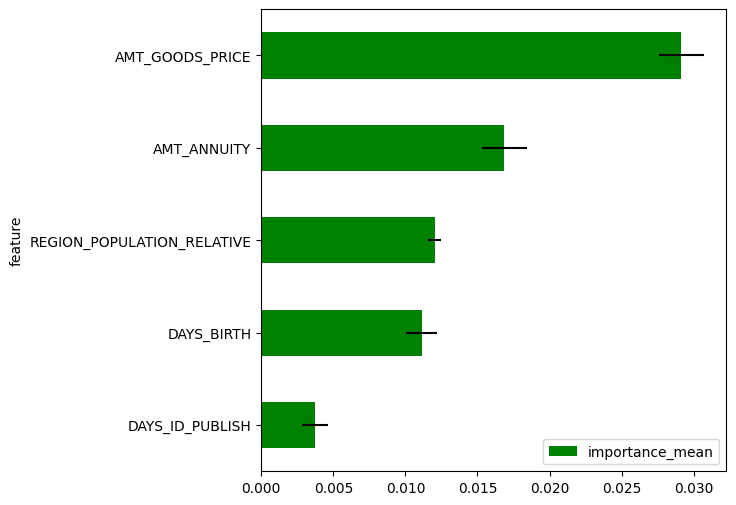

In [ ]:
plot_importance(importance_df.head(10), figsize=(6, 6))

# 5) Hyperparametre optimizasyonu

Cok uzun surdugu icin bu islemi CatBoost icin sadece 10 iterasyonda yapacagiz fakat ayni sekilde Ridge ve diger algoritmalar da denenebilir.

In [ ]:
import optuna

# CatBoostClassifier modeli için hiperparametrelerin aralığını belirleme
def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
        'bagging_temperature': trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),
        'random_strength': trial.suggest_int('random_strength', 1, 100),
        'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
        'od_wait': trial.suggest_int('od_wait', 10, 50),
        'verbose': False
    }

    # Modeli eğitme
    model = CatBoostClassifier(**params)
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=50, verbose=False)

    # Doğruluk skorunu hesaplama
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    return accuracy


In [ ]:
# Optuna'yı kullanarak hiperparametre optimizasyonu yapma
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

# En iyi hiperparametreleri yazdırma
print('Best trial:')
trial = study.best_trial
print('  Score: {}'.format(trial.value))
print('  Params: ')
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

[I 2023-05-11 10:25:59,489] A new study created in memory with name: no-name-4297ca15-75a3-4bbc-9a50-24bb20da6d92
<ipython-input-74-52b9b6c9b6a7>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
<ipython-input-74-52b9b6c9b6a7>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'bagging_temperature': trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),
[I 2023-05-11 10:26:32,064] Trial 0 finished with value: 0.9205404614409053 and parameters: {'iterations': 635, 'depth': 9, 'learning_rate': 0.2711622841811258, 'bagging_temperature': 0.6249355826416092, 'random_strengt

Best trial:
  Score: 0.9209794644163699
  Params: 
    iterations: 380
    depth: 10
    learning_rate: 0.06892608553012712
    bagging_temperature: 0.8965652441649004
    random_strength: 32
    od_type: Iter
    od_wait: 46


Best trial:

  Score: 0.9209794644163699
  
  Params: 
  
    iterations: 380
  
    depth: 10
  
    learning_rate: 0.06892608553012712
  
    bagging_temperature: 0.8965652441649004
  
    random_strength: 32
  
    od_type: Iter
  
    od_wait: 46

Optuna, CatBoost icin en iyi parametreleri vermis oldu. Bu parametreler ile tekrar egitilmesi durumunda  *accuracy degeri 0.920* olarak hesaplanmistir.

# 6) Degerlendirme

Modelin daha iyi performans vermesi icin yapilabilecekler gerekenler:
* Eksik degerleri ortalama ve en cok tekrar eden degerler ile degistirdik bu her zaman yeterli sonuclari vermeyebilir.
* Feature selection kisminda cok fazla uzun surdugu icin sadece birkac feature ile denedik fakat tum veri setindeki featurelarin etkilerini model uzerinde gorebildigmiz zaman,model uzerindeki etkisine gore featurelari cikartabilir veya etkilerini arttirabilirdik.
* Optuna ile yaptigimiz Hyperparametre optimizasyonunu daha genis aralik ve daha fazla parametre ile yaparsak daha dogru sonuclar elde edecegimiz parametre degerlerine ulasabiliriz.
* *accuracy* metrigi yerine *F1score* veya *roc_auc* metrigini kullanmamiz daha iyi olurdu cunku veri setimiz dengesiz bir dagilima sahip 
* Normalizasyon ve Standardizasyon islemi yapilabilirdi cunku bazi algoritmalar degerler arasindaki mesafelere bagli olarak performanslari degisiyor bu yuzden sayisal degerleri 0-1 veya 0-255 gibi araliklara cekebiliriz.
* Daha fazla Veri Analizi yapilabilir ve ona gore veriler sekillendirilebilirdi. Ornegin aykiri degerler, ceyrek dilimler belirlenerek hesaplanan bir esik degeri ile veriden cikartilabilir veya esik degerine baskilanabilirdi. 
* Model Validasyonu icin basit bir sekilde train test split yerine KFold, StratifiedKFold gibi yontemlerde kullanilabilirdi. Bu sekilde daha verimli degerlendirme saglanabilirdi.

# Sonuc
Uzun zamandir sadece dogal dil isleme ve goruntu isleme gibi konular uzerinde birseyler ogrenmeye calistigim icin bu konulara uzak kaldim. Bir cok islemi arastirip yapmam gerekti o yuzden biraz karisik oldu.